In [1]:
# Import libraries
import expectexception

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

In [2]:
# Global variables
sqlite_db   = 'datasets/chinook.db'
title_param = {'color': 'darkred', 'fontsize': 12}

In [3]:
# Read data
classic_18 = pd.read_csv('datasets/classic_18.csv', index_col=0)
classic_19 = pd.read_csv('datasets/classic_19.csv', index_col=0)
pop_18     = pd.read_csv('datasets/pop_18.csv', index_col=0)
pop_19     = pd.read_csv('datasets/pop_19.csv', index_col=0)

#-----------------First method using sqlalchemy
engine = create_engine("sqlite:///" + sqlite_db)

genres = pd.read_sql("genres", engine); 
albums = pd.read_sql("albums", engine); 
tracks = pd.read_sql("tracks", engine); 
invoice_items = pd.read_sql("invoice_items", engine); 
artists = pd.read_sql("artists", engine);

genres.columns = ['gid', 'name'];
albums.columns = ['aid', 'title', 'artid'];
tracks.columns = ['tid', 'name', 'aid', 'mtid', 'gid', 'composer', 'milliseconds', 'bytes', 'uprice'];
invoice_items.columns = ['ilid', 'iid', 'tid', 'uprice', 'quantity'];
artists.columns = ['artid', 'name']

#-----------------First method using sqlite3
with sqlite3.connect(sqlite_db) as conn:
    top_tracks   = pd.read_sql_query("""
                        SELECT
                            t.TrackId as tid
                            , t.Name as name
                            , t.AlbumId as aid
                            , t.MediaTypeId as mtid 
                            , t.GenreId as gid 
                            , t.Composer as composer
                            , t.UnitPrice as uprice
                            , SUM(i.Quantity) as tsold
                        FROM tracks t
                        INNER JOIN invoice_items i ON i.TrackId = t.TrackId
                        WHERE t.Composer IS NOT NULL
                        GROUP BY 1, 2, 3, 4, 5, 6, 7
                        ORDER BY 8 DESC
                        LIMIT 100;
                                   """, conn)
    top_cust     = pd.read_sql_query("""
                        SELECT
                            CustomerId as cid
                            , SupportRepId as srid
                            , FirstName as fname
                            , LastName as lname 
                            , Phone as phone 
                            , Fax as fax
                            , Email as email
                        FROM customers
                                   """, conn)
    employees    = pd.read_sql_query("""
                        SELECT
                            EmployeeId as srid
                            , LastName as lname 
                            , FirstName as fname
                            , LastName as lname 
                            , Title as title 
                            , HireDate as hire_date
                            , Email as email
                        FROM employees
                                   """, conn)
    top_invoices = pd.read_sql_query("""
                        WITH 
                            top_revenue_items AS
                            (
                                SELECT
                                    t.TrackId as tid
                                    , SUM(i.Quantity * i.UnitPrice) as tsold
                                FROM tracks t
                                INNER JOIN invoice_items i ON i.TrackId = t.TrackId
                                GROUP BY 1
                                ORDER BY 2 DESC
                                LIMIT 8
                            )
                        SELECT 
                            InvoiceLineId as ilid
                            , InvoiceId as iid
                            , TrackId as tid
                            , UnitPrice as uprice
                            , Quantity as quantity
                        FROM
                            invoice_items 
                        WHERE
                            TrackId IN (
                                SELECT tid FROM top_revenue_items
                            )
                                   """, conn)
    non_mus_tcks = pd.read_sql_query("""
                        SELECT
                            t.TrackId as tid
                            , t.Name as name
                            , t.AlbumId as aid
                            , t.MediaTypeId as mtid 
                            , t.GenreId as gid 
                            , t.UnitPrice as uprice
                        FROM tracks t
                        WHERE t.GenreId IN (
                            SELECT GenreId 
                            FROM genres
                            WHERE Name IN ('TV Shows', 'Sci Fi & Fantasy', 'Drama', 'Comedy')
                        );
                                   """, conn)
    invoices     = pd.read_sql_query("""
                        SELECT
                            InvoiceId as iid
                            , CustomerId as cid
                            , InvoiceDate as invoice_date
                            , Total as total
                            , BillingCountry as bill_ctry
                        FROM invoices
                                   """, conn)
    invoices['invoice_date'] = pd.to_datetime(invoices.invoice_date)

# 3. Data Merging Basics

In this chapter, you’ll leverage powerful filtering techniques, including semi-joins and anti-joins. You’ll also learn how to glue DataFrames by vertically combining and using the pandas.concat function to create new datasets. Finally, because data is rarely clean, you’ll also learn how to validate your newly combined data structures.

# <font color=darkred>3.1 Filtering joins</font>

**1. Filtering joins**
>Welcome to the third chapter! In this lesson, we will discuss a type of join called a filtering join. Pandas doesn't provide direct support for filtering joins, but we will learn how to replicate them.

**2. Mutating versus filtering joins**
>So far, we have only worked with mutating joins, which combines data from two tables. However, filtering joins filter observations from one table based on whether or not they match an observation in another table.

**3. What is a semi-join?**
>Let's start with a semi-join. A semi-join filters the left table down to those observations that have a match in the right table. It is similar to an inner join where only the intersection between the tables is returned, but unlike an inner join, only the columns from the left table are shown. Finally, no duplicate rows from the left table are returned, even if there is a one-to-many relationship. Let's look at an example.

**4. Musical dataset**
>For this chapter, the dataset we will use is from an online music streaming service.
(1) Photo by Vlad Bagacian from Pexels

**5. Example datasets**
>In this new dataset, we have a table of song genres shown here. There's also a table of top-rated song tracks. The 'gid' column connects the two tables. Let's say we want to find what genres appear in our table of top songs. A semi-join would return only the columns from the genre table and not the tracks.

**6. Step 1 - semi-join**
>First, let's merge the two tables with an inner join. We also print the first few rows of the genres_tracks variable. Since this is an inner join, the returned 'gid' column holds only values where both tables matched.

**7. Step 2 - semi-join**
>For the next step in the technique, let's focus on this line of code. It uses a method called isin(), which compares every 'gid' in the genres table to the 'gid' in the genres_tracks table. This will tell us if our genre appears in our merged genres_tracks table.

**8. Step 2 - semi-join**
>This line of code returns a Boolean Series of true or false values.

**9. Step 3 - semi-join**
>To combine everything, we use that line of code to subset the genres table. The results are saved to top_genres and we print a few rows. We've completed a semi-join. These are rows in the genre table that are also found in the top_tracks table. This is called a filtering join because we've filtered the genres table by what's in the top_tracks table.

**10. What is an anti-join?**
>Now let's talk about anti-joins. An anti-join returns the observations in the left table that do not have a matching observation in the right table. It also only returns the columns from the left table. Now, let's go back to our example. Instead of finding which genres are in the table of top tracks, let's now find which genres are not with an anti-join.

**11. Step 1 - anti-join**
>The first step is to use a left join returning all of the rows from the left table. Here we'll use the indicator argument and set it to True. With indicator set to True, the merge method adds a column called "_merge" to the output. This column tells the source of each row. For example, the first four rows found a match in both tables, whereas the last can only be found in the left table.

**12. Step 2 - anti-join**
>Next, we use the "loc" accessor and "_merge" column to select the rows that only appeared in the left table and return only the "gid" column from the genres_tracks table. We now have a list of gids not in the tracks table.

**13. Step 3 - anti-join**
>In our final step we use the isin() method to filter for the rows with gids in our gid_list. Our output shows those genres not in the tracks table.

**14. Let's practice!**
>Now, your turn.

### <font color=darkblue><u>DATA</u></font>

In [4]:
genres.head()

,gid,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll


In [5]:
top_tracks.head()

,tid,name,aid,mtid,gid,composer,uprice,tsold
0,8,Inject The Venom,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99,2
1,9,Snowballed,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99,2
2,20,Overdose,4,1,1,AC/DC,0.99,2
3,32,Deuces Are Wild,5,1,1,"Steven Tyler, Jim Vallance",0.99,2
4,48,Not The Doctor,6,1,1,Alanis Morissette & Glenn Ballard,0.99,2


### <font color=darkblue><u>SEMI JOINS</u></font>

In [6]:
# Step 1
genres_tracks = genres.merge(top_tracks, on='gid')
# Steo 2
top_genres = genres[genres['gid'].isin(genres_tracks['gid'])]
# Step 3
top_genres.head()

,gid,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
5,6,Blues


In [7]:
# Same as code before
genres[genres.gid.isin(top_tracks.gid)].head()

,gid,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
5,6,Blues


### <font color=darkblue><u>ANTI JOINS</u></font>

In [8]:
# Step 1
genres_tracks = genres.merge(top_tracks, on='gid', how='left', indicator=True)
print(genres_tracks.head())
# Steo 2
gid_list = genres_tracks.loc[genres_tracks['_merge'] == 'left_only', 'gid']
# Step 3
non_top_genres = genres[genres['gid'].isin(gid_list)]
non_top_genres.head()

   gid name_x   tid            name_y  aid  mtid  \
0    1   Rock   8.0  Inject The Venom  1.0   1.0   
1    1   Rock   9.0        Snowballed  1.0   1.0   
2    1   Rock  20.0          Overdose  4.0   1.0   
3    1   Rock  32.0   Deuces Are Wild  5.0   1.0   
4    1   Rock  48.0    Not The Doctor  6.0   1.0   

                                    composer  uprice  tsold _merge  
0  Angus Young, Malcolm Young, Brian Johnson    0.99    2.0   both  
1  Angus Young, Malcolm Young, Brian Johnson    0.99    2.0   both  
2                                      AC/DC    0.99    2.0   both  
3                 Steven Tyler, Jim Vallance    0.99    2.0   both  
4          Alanis Morissette & Glenn Ballard    0.99    2.0   both  


,gid,name
4,5,Rock And Roll
8,9,Pop
9,10,Soundtrack
10,11,Bossa Nova
11,12,Easy Listening


In [9]:
# Same as code before
genres[~genres.gid.isin(top_tracks.gid)].head()

,gid,name
4,5,Rock And Roll
8,9,Pop
9,10,Soundtrack
10,11,Bossa Nova
11,12,Easy Listening


# <font color=darkred>3.2 Steps of a semi-join</font> 

In the last video, you were shown how to perform a semi-join with pandas. In this exercise, you'll solidify your understanding of the necessary steps. Recall that a semi-join filters the left table to only the rows where a match exists in both the left and right tables.

**Instructions**

Sort the steps in the correct order of the technique shown to perform a semi-join in pandas.

**Results**

Steps:
<font color=red>
1. Merge the left and right tables on key column using an inner-join.
2. Search if the key column in the left table is in the merged tables using the .isin() method creating a Boolean Series.
3. Subset the rows of the table.
</font>

<font color=darkgreen>Congratulations! You have a sense of the steps in this technique. It first merges the tables, then searches it for which rows belong in the final result creating a filter and subsets the left table with that filter.</font>

# <font color=darkred>3.3 Performing an anti-join</font> 

In our music streaming company dataset, each customer is assigned an employee representative to assist them. In this exercise, filter the employee table by a table of top customers, returning only those employees who are not assigned to a customer. The results should resemble the results of an anti-join. The company's leadership will assign these employees additional training so that they can work with high valued customers.

The top_cust and employees tables have been provided for you.

**Instructions**
1. Merge employees and top_cust with a left join, setting indicator argument to True. Save the result to empl_cust.
2. Select the srid column of empl_cust and the rows where _merge is 'left_only'. Save the result to srid_list.

**Results**

<font color=darkgreen>Success! You performed an anti-join by first merging the tables with a left join, selecting the ID of those employees who did not support a top customer, and then subsetting the original employee's table. From that, we can see that there are five employees not supporting top customers. Anti-joins are a powerful tool to filter a main table (i.e. employees) by another (i.e. customers).</font>

### <font color=darkblue><u>DATA</u></font>

In [10]:
print(top_cust.shape)
top_cust.head()

(59, 7)


,cid,srid,fname,lname,phone,fax,email
0,1,3,Luís,Gonçalves,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br
1,2,5,Leonie,Köhler,+49 0711 2842222,None,leonekohler@surfeu.de
2,3,3,François,Tremblay,+1 (514) 721-4711,None,ftremblay@gmail.com
3,4,4,Bjørn,Hansen,+47 22 44 22 22,None,bjorn.hansen@yahoo.no
4,5,4,František,Wichterlová,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com


In [11]:
print(employees.shape)
employees.head()

(8, 7)


,srid,lname,fname,lname,title,hire_date,email
0,1,Adams,Andrew,Adams,General Manager,2002-08-14 00:00:00,andrew@chinookcorp.com
1,2,Edwards,Nancy,Edwards,Sales Manager,2002-05-01 00:00:00,nancy@chinookcorp.com
2,3,Peacock,Jane,Peacock,Sales Support Agent,2002-04-01 00:00:00,jane@chinookcorp.com
3,4,Park,Margaret,Park,Sales Support Agent,2003-05-03 00:00:00,margaret@chinookcorp.com
4,5,Johnson,Steve,Johnson,Sales Support Agent,2003-10-17 00:00:00,steve@chinookcorp.com


### <font color=darkblue><u>ANTI JOINS</u></font>

In [12]:
# Merge employees and top_cust
empl_cust = employees.merge(top_cust, on='srid', how='left', indicator=True)

# Select the srid column where _merge is left_only
srid_list = empl_cust.loc[empl_cust['_merge'] == 'left_only', 'srid']

# Get employees not working with top customers
employees[employees.srid.isin(srid_list)]

,srid,lname,fname,lname,title,hire_date,email
0,1,Adams,Andrew,Adams,General Manager,2002-08-14 00:00:00,andrew@chinookcorp.com
1,2,Edwards,Nancy,Edwards,Sales Manager,2002-05-01 00:00:00,nancy@chinookcorp.com
5,6,Mitchell,Michael,Mitchell,IT Manager,2003-10-17 00:00:00,michael@chinookcorp.com
6,7,King,Robert,King,IT Staff,2004-01-02 00:00:00,robert@chinookcorp.com
7,8,Callahan,Laura,Callahan,IT Staff,2004-03-04 00:00:00,laura@chinookcorp.com


In [13]:
# Same as above but in one line of code
employees[~employees.srid.isin(top_cust.srid)]

,srid,lname,fname,lname,title,hire_date,email
0,1,Adams,Andrew,Adams,General Manager,2002-08-14 00:00:00,andrew@chinookcorp.com
1,2,Edwards,Nancy,Edwards,Sales Manager,2002-05-01 00:00:00,nancy@chinookcorp.com
5,6,Mitchell,Michael,Mitchell,IT Manager,2003-10-17 00:00:00,michael@chinookcorp.com
6,7,King,Robert,King,IT Staff,2004-01-02 00:00:00,robert@chinookcorp.com
7,8,Callahan,Laura,Callahan,IT Staff,2004-03-04 00:00:00,laura@chinookcorp.com


# <font color=darkred>3.4 Performing a semi-join</font> 

Some of the tracks that have generated the most significant amount of revenue are from TV-shows or are other non-musical audio. You have been given a table of invoices that include top revenue-generating items. Additionally, you have a table of non-musical tracks from the streaming service. In this exercise, you'll use a semi-join to find the top revenue-generating non-musical tracks..

The tables non_mus_tcks, top_invoices, and genres have been loaded for you.

**Instructions**
1. Merge non_mus_tcks and top_invoices on tid using an inner join. Save the result as tracks_invoices.
2. Use .isin() to subset the rows of non_mus_tck where tid is in the tid column of tracks_invoices. Save the result as top_tracks.
3. Group top_tracks by gid and count the tid rows. Save the result to cnt_by_gid.
4. Merge cnt_by_gid with the genres table on gid and print the result.

**Results**

<font color=darkgreen>Nice job! In this exercise, you replicated a semi-join to filter the table of tracks by the table of invoice items to find the top revenue non-musical tracks. With some additional data manipulation, you discovered that 'TV-shows' is the non-musical genre that has the most top revenue-generating tracks. Now that you've done both semi- and anti-joins, it's time to move to the next topic.</font>

### <font color=darkblue><u>DATA</u></font>

In [14]:
print(non_mus_tcks.shape)
non_mus_tcks.head()

(200, 6)


,tid,name,aid,mtid,gid,uprice
0,2820,Occupation / Precipice,227,3,19,1.99
1,2821,"Exodus, Pt. 1",227,3,19,1.99
2,2822,"Exodus, Pt. 2",227,3,19,1.99
3,2823,Collaborators,227,3,19,1.99
4,2824,Torn,227,3,19,1.99


In [15]:
print(top_invoices.shape)
top_invoices.head()

(16, 5)


,ilid,iid,tid,uprice,quantity
0,470,88,2832,1.99,1
1,2190,404,2832,1.99,1
2,473,88,2850,1.99,1
3,2192,404,2850,1.99,1
4,476,88,2868,1.99,1


In [16]:
print(genres.shape)
genres.head()

(25, 2)


,gid,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll


### <font color=darkblue><u>SEMI JOINS</u></font>

In [17]:
# Merge the non_mus_tck and top_invoices tables on tid
tracks_invoices = non_mus_tcks.merge(top_invoices, on='tid')

# Use .isin() to subset non_mus_tcks to rows with tid in tracks_invoices
top_tracks = non_mus_tcks[non_mus_tcks['tid'].isin(tracks_invoices.tid)]

# Group the top_tracks by gid and count the tid rows
cnt_by_gid = top_tracks.groupby(['gid'], as_index=False).agg({'tid':'count'})
#cnt_by_gid = top_tracks.groupby(['gid'], as_index=False)['tid'].count()

# Merge the genres table to cnt_by_gid on gid and print
cnt_by_gid.merge(genres, on='gid')

,gid,tid,name
0,19,4,TV Shows
1,21,2,Drama
2,22,1,Comedy


In [18]:
# Same as above but in one line of code
non_mus_tcks[non_mus_tcks.tid.isin(top_invoices.tid)].groupby('gid', as_index=False)['tid'].count().merge(genres, on='gid')

,gid,tid,name
0,19,4,TV Shows
1,21,2,Drama
2,22,1,Comedy


# <font color=darkred>3.5 Concatenate DataFrames together vertically</font>

**1. Concatenate DataFrames together vertically**
>Hello there! In this lesson, we'll talk about how to connect two tables vertically.

**2. Concatenate two tables vertically**
>So far in this course, we have only discussed how to merge two tables, which mainly grows them horizontally. But what if we wanted to grow them vertically? We can use the concat method to concatenate, or stick tables together, vertically or horizontally, but in this lesson, we'll focus on vertical concatenation.

**3. Basic concatenation**
>Often, data for different periods of time will come in multiple tables, but if we want to analyze it together, we'll need to combine them into one. Here are three separate tables of invoice data from our streaming service. Notice the column headers are the same. The separate tables are named "inv" underscore Jan through March.

**4. Basic concatenation**
>We can pass a list of table names into pandas dot concat to combine the tables in the order they're passed in. To concatenate vertically, the axis argument should be set to 0, but 0 is the default, so we don't need to explicitly write this. The result is a vertically combined table. Notice each table's index value was retained.

**5. Ignoring the index**
>If the index contains no valuable information, then we can ignore it in the concat method by setting ignore_index to True. The result is that the index will go from 0 to n-1.

**6. Setting labels to original tables**
>Now, suppose we wanted to associate specific keys with each of the pieces of our three original tables. We can provide a list of labels to the keys argument. Make sure that ignore_index argument is False, since you can't add a key and ignore the index at the same time. This results in a table with a multi-index, with the label on the first level.

**7. Concatenate tables with different column names**
>What if we need to combine tables that have different column names? The "inv_feb" table now has a column added for billing country.

**8. Concatenate tables with different column names**
>The concat method by default will include all of the columns in the different tables it's combining. The sort argument, if true, will alphabetically sort the different column names in the result. We can see in the result that the billing country for January invoices is NaN. However, there are values for the February invoices.

**9. Concatenate tables with different column names**
>If we only want the matching columns between tables, we set the join argument to "inner". Its default value is equal to "outer", which is why concat by default will include all of the columns. Additionally, the sort argument has no effect when join equals "inner". The order of the columns will be the same as the input tables. Now the bill country column is gone and we're left with only the columns the tables have in common.

**10. Using append method**
>Now let's briefly talk about append. Append is a simplified concat method. It supports the ignore_index and sort arguments. However, it does not support keys or join. Join is always set to outer.

**11. Append these tables**
>Let's combine these tables with the append method.

**12. Append the tables**
>Append is a DataFrame method therefore, we list the "inv_jan" table first then call the method. We add the other tables as a list, and set the ignore_index and sort arguments similar to the concat method. In our output, we see null values for the billing country, except for February. Additionally, the index is adjusted as expected.

**13. Let's practice!**
>With that, let's get some practice in!

### <font color=darkblue><u>DATA</u></font>

In [19]:
inv_jan= invoices[invoices.invoice_date.dt.month==1].iloc[:3, :-1].reset_index(drop=True)
inv_jan

,iid,cid,invoice_date,total
0,1,2,2009-01-01,1.98
1,2,4,2009-01-02,3.96
2,3,8,2009-01-03,5.94


In [20]:
inv_feb= invoices[invoices.invoice_date.dt.month==2].iloc[:3, :-1].reset_index(drop=True)
inv_feb

,iid,cid,invoice_date,total
0,7,38,2009-02-01,1.98
1,8,40,2009-02-01,1.98
2,9,42,2009-02-02,3.96


In [21]:
inv_feb_c= invoices[invoices.invoice_date.dt.month==2].iloc[:3, :].reset_index(drop=True)
inv_feb_c

,iid,cid,invoice_date,total,bill_ctry
0,7,38,2009-02-01,1.98,Germany
1,8,40,2009-02-01,1.98,France
2,9,42,2009-02-02,3.96,France


In [22]:
inv_mar= invoices[invoices.invoice_date.dt.month==3].iloc[:3, :-1].reset_index(drop=True)
inv_mar

,iid,cid,invoice_date,total
0,14,17,2009-03-04,1.98
1,15,19,2009-03-04,1.98
2,16,21,2009-03-05,3.96


### <font color=darkblue><u>USING pd.concat</u></font>

In [23]:
# Basic concatenation
pd.concat([inv_jan, inv_feb, inv_mar])

,iid,cid,invoice_date,total
0,1,2,2009-01-01,1.98
1,2,4,2009-01-02,3.96
2,3,8,2009-01-03,5.94
0,7,38,2009-02-01,1.98
1,8,40,2009-02-01,1.98
2,9,42,2009-02-02,3.96
0,14,17,2009-03-04,1.98
1,15,19,2009-03-04,1.98
2,16,21,2009-03-05,3.96


In [24]:
# Ignoring the index
pd.concat([inv_jan, inv_feb, inv_mar], ignore_index=True)

,iid,cid,invoice_date,total
0,1,2,2009-01-01,1.98
1,2,4,2009-01-02,3.96
2,3,8,2009-01-03,5.94
3,7,38,2009-02-01,1.98
4,8,40,2009-02-01,1.98
5,9,42,2009-02-02,3.96
6,14,17,2009-03-04,1.98
7,15,19,2009-03-04,1.98
8,16,21,2009-03-05,3.96


In [25]:
# Setting labels to original tables
pd.concat([inv_jan, inv_feb, inv_mar], ignore_index=False, keys=['jan','feb','mar'])

iid  cid invoice_date  total
jan 0    1    2   2009-01-01   1.98
    1    2    4   2009-01-02   3.96
    2    3    8   2009-01-03   5.94
feb 0    7   38   2009-02-01   1.98
    1    8   40   2009-02-01   1.98
    2    9   42   2009-02-02   3.96
mar 0   14   17   2009-03-04   1.98
    1   15   19   2009-03-04   1.98
    2   16   21   2009-03-05   3.96

In [26]:
# Concatenate tables with different column names
pd.concat([inv_jan, inv_feb_c], sort=True)

,bill_ctry,cid,iid,invoice_date,total
0,NaN,2,1,2009-01-01,1.98
1,NaN,4,2,2009-01-02,3.96
2,NaN,8,3,2009-01-03,5.94
0,Germany,38,7,2009-02-01,1.98
1,France,40,8,2009-02-01,1.98
2,France,42,9,2009-02-02,3.96


In [27]:
# Concatenate tables with different column names
pd.concat([inv_jan, inv_feb], join='inner')

,iid,cid,invoice_date,total
0,1,2,2009-01-01,1.98
1,2,4,2009-01-02,3.96
2,3,8,2009-01-03,5.94
0,7,38,2009-02-01,1.98
1,8,40,2009-02-01,1.98
2,9,42,2009-02-02,3.96


### <font color=darkblue><u>USING .append</u></font>

In [28]:
# Append the tables
inv_jan.append([inv_feb_c, inv_mar], ignore_index=True, sort=True)

,bill_ctry,cid,iid,invoice_date,total
0,NaN,2,1,2009-01-01,1.98
1,NaN,4,2,2009-01-02,3.96
2,NaN,8,3,2009-01-03,5.94
3,Germany,38,7,2009-02-01,1.98
4,France,40,8,2009-02-01,1.98
5,France,42,9,2009-02-02,3.96
6,NaN,17,14,2009-03-04,1.98
7,NaN,19,15,2009-03-04,1.98
8,NaN,21,16,2009-03-05,3.96


# <font color=darkred>3.6 Concatenation basics</font> 

You have been given a few tables of data with musical track info for different albums from the metal band, Metallica. The track info comes from their Ride The Lightning, Master Of Puppets, and St. Anger albums. Try various features of the .concat() method by concatenating the tables vertically together in different ways.

The tables tracks_master, tracks_ride, and tracks_st have loaded for you.

**Instructions**
1. Concatenate tracks_master, tracks_ride, and tracks_st, in that order, setting sort to True.
2. Concatenate tracks_master, tracks_ride, and tracks_st, where the index goes from 0 to n-1.
3. Concatenate tracks_master, tracks_ride, and tracks_st, showing only columns that are in all tables.

**Results**

<font color=darkgreen>Great job! You've concatenated your first set of tables, adjusted the index, and altered the columns shown in the output. The .concat() method is a very flexible tool that is useful for combining data into a new dataset.</font>

### <font color=darkblue><u>DATA</u></font>

In [29]:
cols_to_select = ['tid','name','aid','mtid','gid','uprice']
filter_album   = tracks.aid.isin(albums[albums.title=='Ride The Lightning'].aid)
tracks_ride    = tracks[filter_album][cols_to_select].head().reset_index(drop=True)
tracks_ride

,tid,name,aid,mtid,gid,uprice
0,1874,Fight Fire With Fire,154,1,3,0.99
1,1875,Ride The Lightning,154,1,3,0.99
2,1876,For Whom The Bell Tolls,154,1,3,0.99
3,1877,Fade To Black,154,1,3,0.99
4,1878,Trapped Under Ice,154,1,3,0.99


In [30]:
cols_to_select = ['tid','name','aid','mtid','gid','composer','uprice']
filter_album   = tracks.aid.isin(albums[albums.title=='Master Of Puppets'].aid)
tracks_master  = tracks[filter_album][cols_to_select].head(3).reset_index(drop=True)
tracks_master

,tid,name,aid,mtid,gid,composer,uprice
0,1853,Battery,152,1,3,J.Hetfield/L.Ulrich,0.99
1,1854,Master Of Puppets,152,1,3,K.Hammett,0.99
2,1855,The Thing That Should Not Be,152,1,3,K.Hammett,0.99


In [31]:
cols_to_select = ['tid','name','aid','mtid','gid','uprice']
filter_album   = tracks.aid.isin(albums[albums.title=='St. Anger'].aid)
tracks_st      = tracks[filter_album][cols_to_select].head().reset_index(drop=True)
tracks_st

,tid,name,aid,mtid,gid,uprice
0,1882,Frantic,155,1,3,0.99
1,1883,St. Anger,155,1,3,0.99
2,1884,Some Kind Of Monster,155,1,3,0.99
3,1885,Dirty Window,155,1,3,0.99
4,1886,Invisible Kid,155,1,3,0.99


### <font color=darkblue><u>USING pd.concat</u></font>

In [32]:
# Concatenate the tracks
pd.concat([tracks_master, tracks_ride, tracks_st], sort=True, keys=['master', 'ride', 'st'])

aid             composer  gid  mtid                          name  \
master 0  152  J.Hetfield/L.Ulrich    3     1                       Battery   
       1  152            K.Hammett    3     1             Master Of Puppets   
       2  152            K.Hammett    3     1  The Thing That Should Not Be   
ride   0  154                  NaN    3     1          Fight Fire With Fire   
       1  154                  NaN    3     1            Ride The Lightning   
       2  154                  NaN    3     1       For Whom The Bell Tolls   
       3  154                  NaN    3     1                 Fade To Black   
       4  154                  NaN    3     1             Trapped Under Ice   
st     0  155                  NaN    3     1                       Frantic   
       1  155                  NaN    3     1                     St. Anger   
       2  155                  NaN    3     1          Some Kind Of Monster   
       3  155                  NaN    3     1                  Dirty Window   
       4  155                  NaN    3     1                 Invisible Kid   

           tid  uprice  
master 0  1853    0.99  
       1  1854    0.99  
       2  1855    0.99  
ride   0  1874    0.99  
       1  1875    0.99  
       2  1876    0.99  
       3  1877    0.99  
       4  1878    0.99  
st     0  1882    0.99  
       1  1883    0.99  
       2  1884    0.99  
       3  1885    0.99  
       4  1886    0.99

In [33]:
# Concatenate the tracks so the index goes from 0 to n-1
pd.concat([tracks_master, tracks_ride, tracks_st], ignore_index=True, sort=True)

,aid,composer,gid,mtid,name,tid,uprice
0,152,J.Hetfield/L.Ulrich,3,1,Battery,1853,0.99
1,152,K.Hammett,3,1,Master Of Puppets,1854,0.99
2,152,K.Hammett,3,1,The Thing That Should Not Be,1855,0.99
3,154,NaN,3,1,Fight Fire With Fire,1874,0.99
4,154,NaN,3,1,Ride The Lightning,1875,0.99
5,154,NaN,3,1,For Whom The Bell Tolls,1876,0.99
6,154,NaN,3,1,Fade To Black,1877,0.99
7,154,NaN,3,1,Trapped Under Ice,1878,0.99
8,155,NaN,3,1,Frantic,1882,0.99
9,155,NaN,3,1,St. Anger,1883,0.99


In [34]:
# Concatenate the tracks, show only columns names that are in all tables
pd.concat([tracks_master, tracks_ride, tracks_st], join='inner', sort=True)

,aid,gid,mtid,name,tid,uprice
0,152,3,1,Battery,1853,0.99
1,152,3,1,Master Of Puppets,1854,0.99
2,152,3,1,The Thing That Should Not Be,1855,0.99
0,154,3,1,Fight Fire With Fire,1874,0.99
1,154,3,1,Ride The Lightning,1875,0.99
2,154,3,1,For Whom The Bell Tolls,1876,0.99
3,154,3,1,Fade To Black,1877,0.99
4,154,3,1,Trapped Under Ice,1878,0.99
0,155,3,1,Frantic,1882,0.99
1,155,3,1,St. Anger,1883,0.99


# <font color=darkred>3.7 Concatenating with keys</font> 

The leadership of the music streaming company has come to you and asked you for assistance in analyzing sales for a recent business quarter. They would like to know which month in the quarter saw the highest average invoice total. You have been given three tables with invoice data named inv_jul, inv_aug, and inv_sep. Concatenate these tables into one to create a graph of the average monthly invoice total.

**Instructions**

1. Concatenate the three tables together vertically in order with the oldest month first, adding '7Jul', '8Aug', and '9Sep' as keys for their respective months, and save to variable avg_inv_by_month.
2. Use the .agg() method to find the average of the total column from the grouped invoices.
3. Create a bar chart of avg_inv_by_month.

**Results**

<font color=darkgreen>Way to come through! There are many ways to write code for this task. However, concatenating the tables with a key provides a hierarchical index that can be used for grouping. Once grouped, you can average the groups and create plots. You were able to find out that September had the highest average invoice total.</font>

### <font color=darkblue><u>DATA</u></font>

In [35]:
inv_jul= invoices[invoices.invoice_date.dt.month==7].reset_index(drop=True)
print(inv_jul.shape)
inv_jul.head()

(35, 5)


,iid,cid,invoice_date,total,bill_ctry
0,42,51,2009-07-06,1.98,Sweden
1,43,53,2009-07-06,1.98,United Kingdom
2,44,55,2009-07-07,3.96,Australia
3,45,59,2009-07-08,5.94,India
4,46,6,2009-07-11,8.91,Czech Republic


In [36]:
inv_aug= invoices[invoices.invoice_date.dt.month==8].reset_index(drop=True)
print(inv_aug.shape)
inv_aug.head()

(35, 5)


,iid,cid,invoice_date,total,bill_ctry
0,49,30,2009-08-06,1.98,Canada
1,50,32,2009-08-06,1.98,Canada
2,51,34,2009-08-07,3.96,Portugal
3,52,38,2009-08-08,5.94,Germany
4,53,44,2009-08-11,8.91,Finland


In [37]:
inv_sep= invoices[invoices.invoice_date.dt.month==9].reset_index(drop=True)
print(inv_sep.shape)
inv_sep.head()

(33, 5)


,iid,cid,invoice_date,total,bill_ctry
0,56,9,2009-09-06,1.98,Denmark
1,57,11,2009-09-06,1.98,Brazil
2,58,13,2009-09-07,3.96,Brazil
3,59,17,2009-09-08,5.94,USA
4,60,23,2009-09-11,8.91,USA


### <font color=darkblue><u>USING pd.concat</u></font>

        iid  cid invoice_date  total       bill_ctry
7Jul 0   42   51   2009-07-06   1.98          Sweden
     1   43   53   2009-07-06   1.98  United Kingdom
     2   44   55   2009-07-07   3.96       Australia
     3   45   59   2009-07-08   5.94           India
     4   46    6   2009-07-11   8.91  Czech Republic


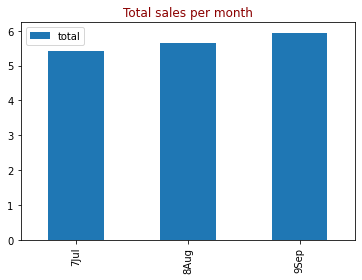

In [38]:
# Concatenate the tables and add keys
inv_jul_thr_sep = pd.concat([inv_jul, inv_aug, inv_sep], keys=['7Jul', '8Aug', '9Sep'])
print(inv_jul_thr_sep.head())

# Group the invoices by the index keys and find avg of the total column
avg_inv_by_month = inv_jul_thr_sep.groupby(level=0).agg({'total':'mean'})

# Bar plot of avg_inv_by_month
avg_inv_by_month.plot(kind='bar')
plt.title('Total sales per month', **title_param)

plt.show()

# <font color=darkred>3.8 Using the append method</font> 

The .concat() method is excellent when you need a lot of control over how concatenation is performed. However, if you do not need as much control, then the .append() method is another option. You'll try this method out by appending the track lists together from different Metallica albums. From there, you will merge it with the invoice_items table to determine which track sold the most.

The tables tracks_master, tracks_ride, tracks_st, and invoice_items have loaded for you.

**Instructions**
1. Use the .append() method to combine (in this order)tracks_ride, tracks_master, and tracks_st together vertically, and save to metallica_tracks.
2. Merge metallica_tracks and invoice_items on tid with an inner join, and save to tracks_invoices.
3. For each tid and name in tracks_invoices, sum the quantity sold column, and save as tracks_sold.
4. Sort tracks_sold in descending order by the quantity column, and print the table.

**Results**

<font color=darkgreen>Great work! Even though .append() is less flexible, it's also simpler than .concat(). It looks like Battery, and For Whom The Bell Tolls were the most sold tracks.</font>

### <font color=darkblue><u>DATA</u></font>

In [39]:
print(invoice_items.shape)
invoice_items.head(2)

(2240, 5)


,ilid,iid,tid,uprice,quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1


### <font color=darkblue><u>USING .append AND .merge</u></font>

In [40]:
# Use the .append() method to combine the tracks tables
metallica_tracks = tracks_ride.append([tracks_master, tracks_st], sort=False)
print(metallica_tracks.shape)
metallica_tracks.head(2)

(13, 7)


,tid,name,aid,mtid,gid,uprice,composer
0,1874,Fight Fire With Fire,154,1,3,0.99,NaN
1,1875,Ride The Lightning,154,1,3,0.99,NaN


In [41]:
# Merge metallica_tracks and invoice_items
tracks_invoices = metallica_tracks.merge(invoice_items, on='tid', suffixes=('_trk','_inv'))
print(tracks_invoices.shape)
tracks_invoices.head(2)

(11, 11)


,tid,name,aid,mtid,gid,uprice_trk,composer,ilid,iid,uprice_inv,quantity
0,1875,Ride The Lightning,154,1,3,0.99,NaN,887,165,0.99,1
1,1876,For Whom The Bell Tolls,154,1,3,0.99,NaN,312,59,0.99,1


In [42]:
# For each tid and name sum the quantity sold
tracks_sold = tracks_invoices.groupby(['tid','name']).agg({'quantity':'sum'})
print(tracks_sold.shape)
tracks_sold.head(2)

(9, 1)


,,quantity
tid,name,
1853,Battery,2
1854,Master Of Puppets,1


In [43]:
# Sort in decending order by quantity and print the results
tracks_sold.sort_values('quantity', ascending=False)

,,quantity
tid,name,
1853,Battery,2
1876,For Whom The Bell Tolls,2
1854,Master Of Puppets,1
1855,The Thing That Should Not Be,1
1875,Ride The Lightning,1
1877,Fade To Black,1
1882,Frantic,1
1884,Some Kind Of Monster,1
1886,Invisible Kid,1


# <font color=darkred>3.9 Verifying integrity</font>

**1. Verifying integrity**
>Welcome back. In this lesson, let's talk about verifying the integrity of our data.

**2. Let's check our data**
>Both the merge and concat methods have special features that allow us to verify the structure of our data. When merging two tables, we might expect the tables to have a one-to-one relationship. However, one of the columns we are merging on may have a duplicated value, which will turn the relationship into a one-to-many. When concatenating tables vertically, we might unintentionally create duplicate records if a record exists in both tables. The validate and verify_integrity arguments of the merge and concat methods respectively will allow us to verify the data.

**3. Validating merges**
>Let's start with the merge method. If we provide the validate argument one of these key strings, it will validate the relationship between the two tables. For example, if we specify we want a one-to-one relationship, but it turns out the relationship is not one-to-one, then an error is raised. Let's try it out.

**4. Merge dataset for example**
>In this example, we want to merge these two tables on the column "tid". Again, our data is from our music service. The first table is named "tracks", and the second is called "specs" for the technical specifications of each track. Each track should have one set of specifications, so this should be a one-to-one merge. However, notice that the specs table has two rows with a "tid" value equal to two. Therefore, merging these tables now becomes, unintentionally, a one-to-many relationship.

**5. Merge validate: one_to_one**
>Let's merge the two tables with the tracks table on the left and specs on the right. Additionally, let's set the validate argument equal to one_to_one. In the result, a MergeError is raised. Python then tells us that the right table has duplicates, so it is not a one-to-one merge. We know that we should handle those duplicates properly before merging.

**6. Merge validate: one_to_many**
>Now we'll merge album information with the tracks table. For every album there are multiple tracks, so this should be a one-to-many relationship. When we set the validate argument to "one_to_many" no error is raised.

**7. Verifying concatenations**
>Let's now talk about the concat method. It has the argument verify_integrity, which by default is False. However, if set to True, it will check if there are duplicate values in the index and raise an error if there are. It will only check the index values and not the columns.

**8. Dataset for .concat() example**
>To try out this feature, we will attempt to concatenate these two tables. They are the February and March invoice data shown in a previous video. However, both tables were modified so the index contains invoice IDs. Notice that invoice ID number 9 is in both tables.

**9. Verifying concatenation: example**
>Let's try to concatenate the two tables together with the verify_integrity argument set to True. The concat method raises a ValueError stating that the indexes have overlapping values. Now let's try to concatenate the two tables again with the verify_integrity set back to the default value of False. The concat method now returns a combined table with the invoice ID of number 9 repeated twice.

**10. Why verify integrity and what to do**
>Often our data is not clean, and it may not always be evident if data has the expected structure. Therefore, verifying this structure is useful, saving us from having a mean skewed by duplicate values, or from creating inaccurate plots. If you receive a MergeError or a ValueError, you can fix the incorrect data or drop duplicate rows. In general, you should look to correct the issue.

**11. Let's practice!**
>Time for some practice!

### <font color=darkblue><u>DATA</u></font>

In [44]:
t_tracks = tracks.loc[1:3, ['tid', 'name', 'aid', 'mtid', 'gid', 'uprice']]
t_tracks

,tid,name,aid,mtid,gid,uprice
1,2,Balls to the Wall,2,2,1,0.99
2,3,Fast As a Shark,3,2,1,0.99
3,4,Restless and Wild,3,2,1,0.99


In [45]:
t_specs = tracks.loc[1:2, ['tid', 'milliseconds', 'bytes']].append(tracks.loc[1, ['tid', 'milliseconds', 'bytes']])
t_specs.head()

,tid,milliseconds,bytes
1,2,342562,5510424
2,3,230619,3990994
1,2,342562,5510424


In [46]:
t_inv_feb= invoices[invoices.invoice_date.dt.month==2].iloc[:3, :-1].reset_index(drop=True).set_index('iid')
t_inv_feb

,cid,invoice_date,total
iid,,,
7,38,2009-02-01,1.98
8,40,2009-02-01,1.98
9,42,2009-02-02,3.96


In [47]:
t_inv_mar= invoices[invoices.invoice_date.dt.month==3].iloc[:3, :-1].reset_index(drop=True).set_index('iid')
t_inv_mar.index = [9, 15, 16]
t_inv_mar

,cid,invoice_date,total
9,17,2009-03-04,1.98
15,19,2009-03-04,1.98
16,21,2009-03-05,3.96


### <font color=darkblue><u>VALIDATING MERGES</u></font>

In [48]:
%%expect_exception pd.errors.MergeError
t_tracks.merge(t_specs, on='tid', validate='one_to_one')

---------------------------------------------------------------------------
MergeError                                Traceback (most recent call last)
<ipython-input-48-6229ed8f9e1c> in <module>
----> 1 t_tracks.merge(t_specs, on='tid', validate='one_to_one')

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py in merge(self, right, how, on, left_on, right_on, left_index, right_index, sort, suffixes, copy, indicator, validate)
   8193         from pandas.core.reshape.merge import merge
   8194 
-> 8195         return merge(
   8196             self,
   8197             right,

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\merge.py in merge(left, right, how, on, left_on, right_on, left_index, right_index, sort, suffixes, copy, indicator, validate)
     72     validate=None,
     73 ) -> "DataFrame":
---> 74     op = _MergeOperation(
     75         left,
     76         right,

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\me

In [49]:
albums.merge(tracks, on='aid', validate='one_to_many').head(3)

,aid,title,artid,tid,name,mtid,gid,composer,milliseconds,bytes,uprice
0,1,For Those About To Rock We Salute You,1,1,For Those About To Rock (We Salute You),1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,1,For Those About To Rock We Salute You,1,6,Put The Finger On You,1,1,"Angus Young, Malcolm Young, Brian Johnson",205662,6713451,0.99
2,1,For Those About To Rock We Salute You,1,7,Let's Get It Up,1,1,"Angus Young, Malcolm Young, Brian Johnson",233926,7636561,0.99


### <font color=darkblue><u>VERIFYING CONCATENATIONS</u></font>

In [50]:
%%expect_exception ValueError
pd.concat([t_inv_feb, t_inv_mar], verify_integrity=True)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-50-ef2ea7158790> in <module>
----> 1 pd.concat([t_inv_feb, t_inv_mar], verify_integrity=True)

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\concat.py in concat(objs, axis, join, ignore_index, keys, levels, names, verify_integrity, sort, copy)
    283     ValueError: Indexes have overlapping values: ['a']
    284     """
--> 285     op = _Concatenator(
    286         objs,
    287         axis=axis,

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\concat.py in __init__(self, objs, axis, join, keys, levels, names, ignore_index, verify_integrity, copy, sort)
    465         self.copy = copy
    466 
--> 467         self.new_axes = self._get_new_axes()
    468 
    469     def get_result(self):

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\concat.py in _get_ne

In [51]:
pd.concat([t_inv_feb, t_inv_mar], verify_integrity=False)

,cid,invoice_date,total
7,38,2009-02-01,1.98
8,40,2009-02-01,1.98
9,42,2009-02-02,3.96
9,17,2009-03-04,1.98
15,19,2009-03-04,1.98
16,21,2009-03-05,3.96


# <font color=darkred>3.10 Validating a merge
</font>

**Instructions**

1. You have been given 2 tables, artists, and albums. Use the console to merge them using artists.merge(albums, on='artid').head(). Adjust the validate argument to answer which statement is False.

**Possible Answers**

- You can use 'many_to_many' without an error, since there is a duplicate key in one of the tables.
- You can use 'one_to_many' without error, since there is a duplicate key in the right table.
- <font color=red><u>You can use 'many_to_one' without an error, since there is a duplicate key in the left table.</u></font>

**Results**

<font color=darkgreen>That's correct! This statement is false. There is a duplicate value in the artid column in the albums table, which is the right table in this merge. Therefore, setting validate equal to 'many_to_one' or 'one_to_one' will raise an error, making this statement false.</font>

### <font color=darkblue><u>DATA</u></font>

In [52]:
print(artists.shape)
artists.head()

(275, 2)


,artid,name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith
3,4,Alanis Morissette
4,5,Alice In Chains


In [53]:
print(albums.shape)
albums.head()

(347, 3)


,aid,title,artid
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2
2,3,Restless and Wild,2
3,4,Let There Be Rock,1
4,5,Big Ones,3


### <font color=darkblue><u>VALIDATING MERGES</u></font>

In [54]:
artists.merge(albums, on='artid').head(2)

,artid,name,aid,title
0,1,AC/DC,1,For Those About To Rock We Salute You
1,1,AC/DC,4,Let There Be Rock


In [55]:
artists.merge(albums, on='artid', validate='one_to_many').head()

,artid,name,aid,title
0,1,AC/DC,1,For Those About To Rock We Salute You
1,1,AC/DC,4,Let There Be Rock
2,2,Accept,2,Balls to the Wall
3,2,Accept,3,Restless and Wild
4,3,Aerosmith,5,Big Ones


In [56]:
artists.merge(albums, on='artid', validate='many_to_many').head()

,artid,name,aid,title
0,1,AC/DC,1,For Those About To Rock We Salute You
1,1,AC/DC,4,Let There Be Rock
2,2,Accept,2,Balls to the Wall
3,2,Accept,3,Restless and Wild
4,3,Aerosmith,5,Big Ones


In [57]:
%%expect_exception pd.errors.MergeError
artists.merge(albums, on='artid', validate='many_to_one').head()

---------------------------------------------------------------------------
MergeError                                Traceback (most recent call last)
<ipython-input-57-109e9a441ae2> in <module>
----> 1 artists.merge(albums, on='artid', validate='many_to_one').head()

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py in merge(self, right, how, on, left_on, right_on, left_index, right_index, sort, suffixes, copy, indicator, validate)
   8193         from pandas.core.reshape.merge import merge
   8194 
-> 8195         return merge(
   8196             self,
   8197             right,

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\reshape\merge.py in merge(left, right, how, on, left_on, right_on, left_index, right_index, sort, suffixes, copy, indicator, validate)
     72     validate=None,
     73 ) -> "DataFrame":
---> 74     op = _MergeOperation(
     75         left,
     76         right,

C:\Anaconda3\envs\datascience\lib\site-packages\pandas\core\re

# <font color=darkred>3.11 Concatenate and merge to find common songs</font> 

The senior leadership of the streaming service is requesting your help again. You are given the historical files for a popular playlist in the classical music genre in 2018 and 2019. Additionally, you are given a similar set of files for the most popular pop music genre playlist on the streaming service in 2018 and 2019. Your goal is to concatenate the respective files to make a large classical playlist table and overall popular music table. Then filter the classical music table using a semi-join to return only the most popular classical music tracks.

The tables classic_18, classic_19, and pop_18, pop_19 have been loaded for you. Additionally, pandas has been loaded as pd.

**Instructions**

1. Concatenate the classic_18 and classic_19 tables vertically where the index goes from 0 to n-1, and save to classic_18_19.
2. Concatenate the pop_18 and pop_19 tables vertically where the index goes from 0 to n-1, and save to pop_18_19.
3. With classic_18_19 on the left, merge it with pop_18_19 on tid using an inner join.
4. Use .isin() to filter classic_18_19 where tid is in classic_pop.

**Results**

<font color=darkgreen>Excellent work! In this exercise, you demonstrated many of the concepts discussed in this chapter, including concatenation, and semi-joins. You now have experience combining data vertically and using semi- and anti-joins. Time to move on to the next chapter!</font>

### <font color=darkblue><u>DATA</u></font>

In [58]:
print(classic_18.shape)
classic_18.head()

(25, 2)


,pid,tid
8527,12,3483
8586,12,3416
8533,12,3489
8523,12,3479
8558,12,3440


In [59]:
print(classic_19.shape)
classic_19.head()

(27, 2)


,pid,tid
8526,12,3482
8552,12,3434
8566,12,3448
8543,12,3499
8595,12,3425


In [60]:
print(pop_18.shape)
pop_18.head()

(176, 2)


,pid,tid
3150,1,3063
315,1,2712
2178,1,2641
2772,1,2271
430,1,919


In [61]:
print(pop_19.shape)
pop_19.head()

(200, 2)


,pid,tid
2639,1,2115
1867,1,297
910,1,272
3107,1,3023
723,1,1193


### <font color=darkblue><u>USING pd.concat AND .merge</u></font>

In [62]:
# Concatenate the classic tables vertically
classic_18_19 = pd.concat([classic_18, classic_19], ignore_index=True)

# Concatenate the pop tables vertically
pop_18_19 = pd.concat([pop_18, pop_19], ignore_index=True)

In [63]:
# Merge classic_18_19 with pop_18_19
classic_pop = classic_18_19.merge(pop_18_19, on='tid', suffixes=('_cla', '_pop'))
classic_pop.head()

,pid_cla,tid,pid_pop
0,12,3479,1
1,12,3439,1
2,12,3445,1
3,12,3449,1
4,12,3437,1


In [64]:
# Using .isin(), filter classic_18_19 rows where tid is in classic_pop
popular_classic = classic_18_19[classic_18_19['tid'].isin(classic_pop.tid)]
popular_classic

,pid,tid
3,12,3479
10,12,3439
21,12,3445
23,12,3449
48,12,3437
50,12,3435


# Aditional material

- Datacamp course: https://learn.datacamp.com/courses/extreme-gradient-boosting-with-xgboost
- Data sourcee: 
    * https://www.sqlitetutorial.net/sqlite-sample-database/
    * https://rstudio-pubs-static.s3.amazonaws.com/636199_f2bbff058f2a4ad99304054b338458b9.html